In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, BayesianRidge, ARDRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.cross_validation import LabelKFold
from ml_metrics import rmsle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])

In [3]:
def select_features(data):
    black_list = ['casual', 'registered', 'count', 'is_test', 'datetime']
    return [feat for feat in data.columns if feat not in black_list]
    
def get_X_y(data, target_var='count'):
    features = select_features(data)
    return data[features].values, data[target_var].values

def validation(data, n_folds=3):
    feats = select_features(data)
    X = data[feats].values
    y = data['count'].values

    labels = data['datetime'].dt.month.values
    
    for train_idx, test_idx in LabelKFold(labels, n_folds=n_folds):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def get_importance_features(data, model, limit, target_variable):
    X,y = get_X_y(data, target_variable)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort_values(by=[0], ascending=False) [:limit]
    return feats.rename(columns={0:'name'})
    
def draw_importance_features(data, model=RandomForestRegressor(), limit=30, target_variable='count'):
    feats = get_importance_features(data, model, limit, target_variable)
    feats.plot(kind='bar', figsize=(20, 8), title="Target variable = {0}".format(target_variable))
    
    
def count_modeling(model, data, feats, n_folds=3):
    X,y  = data[feats].values, data['count'].values

    labels = data['datetime'].dt.month.values
    
    scores = []
    for train_idx, test_idx in LabelKFold(labels, n_folds=n_folds):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        y_pred[y_pred <0 ] = 0
        scores.append(rmsle(y[test_idx], y_pred))
        
    return np.mean(scores), np.std(scores)

## Feature Engineering

There're different type of variables:
- numerical (integer or float)
    - put into different buckets, e.g. you can split age in number into buckets: **children**, **teenagers**, **adults**, **old**
- categorical (e.g. colours blue, white, black)
    - convert into numerical, e.g. a, b, c => 0, 1, 2
    - one hot encoding: crate from one column, n-columns binary, where n is count of unique value
    - convert into probability
- date|datetim
    - extract day, month, year
    - get extra information from excracted parts for day, e.g. is_wekeend, is_holiday in given country and so on

In [4]:
def cat_hour(hour):
    if 5 >= hour < 10:
        return 1#morning
    elif 10 >= hour < 17:
        return 2#day
    elif 17 >= hour < 23:
        return 3 #evening
    else:
        return 4 #night
    
def feature_engineering(data):
    data['year'] = data['datetime'].dt.year
    # you cand add: month, day, hour, minute, dayofweek, weekofyear
    
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['minute'] = data['datetime'].dt.minute
    data['dayofweek'] = data['datetime'].dt.dayofweek
    data['weekofyear'] = data['datetime'].dt.weekofyear
    

    #you can think in this way as well:
    data['weekend'] = data.dayofweek.map(lambda x: int(x in [5,6]) )
    data['time_of_day'] = data['hour'].map(cat_hour)
    
    
feature_engineering(train)

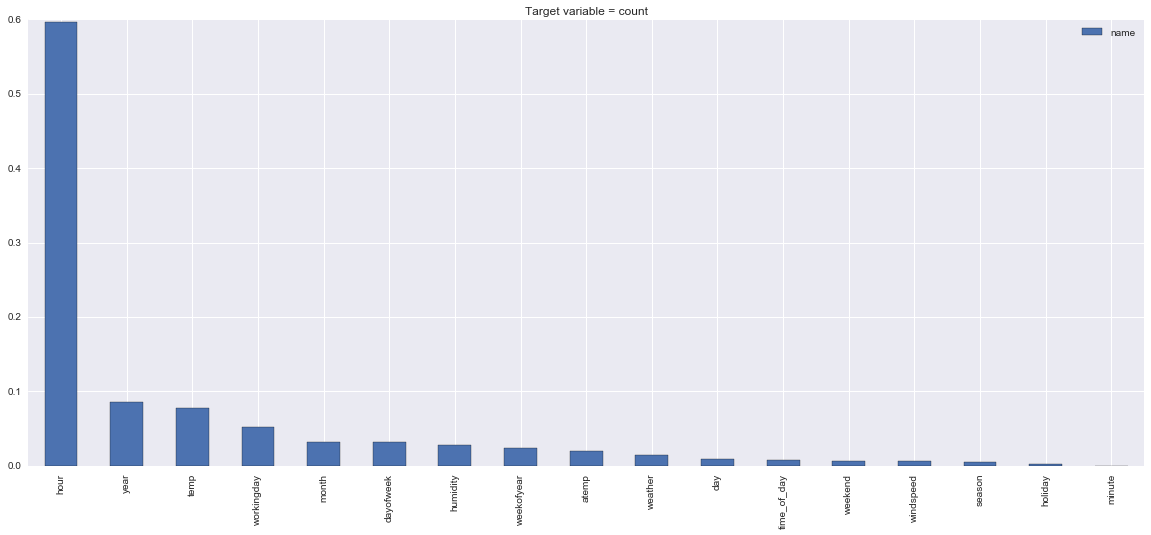

In [5]:
draw_importance_features(train, target_variable='count')

In [6]:
model = RandomForestRegressor()
feats = select_features(train)
count_modeling(model, train, feats)

(0.39576970356681679, 0.014026515141310134)

## Feature Selection

In [7]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

feats = select_features(train)


sel = VarianceThreshold(threshold=(.6 * (1 - .6)))
sel.fit_transform(train[feats], train['count']).shape
print set(np.array(feats)) - set(np.array(feats)[sel.get_support()])


set(['holiday', 'weekend', 'minute', 'workingday'])


In [8]:
def find_the_best_features(data, sel_class, model=RandomForestRegressor(), range_k = range(2, 17), show_top=5):
    feats = select_features(data)
    X,y = data[feats], data['count']

    results = []
    for k in range_k:
        sel = sel_class(k)
        X_new = sel.fit_transform(X, y)

        new_feats = list(set(np.array(feats)[sel.get_support()]) & set(np.array(feats)))
        mean_score, std_score = (count_modeling(model, train, new_feats))
        results.append( (mean_score, std_score, new_feats) )


    return [ (round(x[0], 4), list(x[2])) for x in sorted(results, key=lambda x: x[0])[:show_top] ]

find_the_best_features(train, lambda k: SelectKBest(chi2, k))

[(0.3947,
  ['dayofweek',
   'holiday',
   'hour',
   'temp',
   'time_of_day',
   'season',
   'atemp',
   'humidity',
   'workingday',
   'windspeed',
   'weather',
   'weekofyear',
   'year',
   'month',
   'weekend',
   'day']),
 (0.4867,
  ['dayofweek',
   'holiday',
   'hour',
   'temp',
   'time_of_day',
   'season',
   'atemp',
   'humidity',
   'workingday',
   'windspeed',
   'weather',
   'weekofyear',
   'month',
   'weekend',
   'day']),
 (0.4878,
  ['dayofweek',
   'holiday',
   'hour',
   'temp',
   'season',
   'weekend',
   'atemp',
   'month',
   'time_of_day',
   'windspeed',
   'weekofyear',
   'humidity',
   'workingday',
   'day']),
 (0.4934,
  ['dayofweek',
   'holiday',
   'hour',
   'temp',
   'season',
   'atemp',
   'month',
   'time_of_day',
   'windspeed',
   'weekofyear',
   'humidity',
   'weekend',
   'day']),
 (0.4948,
  ['dayofweek',
   'holiday',
   'hour',
   'temp',
   'atemp',
   'month',
   'time_of_day',
   'windspeed',
   'weekofyear',
   'humid

In [80]:
find_the_best_features(train, lambda k: RFE(model, k, step=1))

[(0.3679,
  "['dayofweek', 'hour', 'temp', 'humidity', 'workingday', 'atemp', 'weather', 'weekofyear', 'year', 'month', 'weekend', 'day']"),
 (0.3685,
  "['dayofweek', 'hour', 'temp', 'atemp', 'humidity', 'workingday', 'windspeed', 'weather', 'weekofyear', 'year', 'month', 'weekend', 'day']"),
 (0.3732,
  "['dayofweek', 'hour', 'weekofyear', 'workingday', 'atemp', 'temp', 'year']"),
 (0.3734,
  "['dayofweek', 'hour', 'temp', 'humidity', 'workingday', 'atemp', 'weather', 'weekofyear', 'year', 'month', 'weekend']"),
 (0.3735,
  "['dayofweek', 'hour', 'temp', 'humidity', 'workingday', 'atemp', 'year', 'month']")]

## Model Selection

In [85]:
models = [ 
    ('extra_tree', ExtraTreesRegressor()),
    ('random_forest', RandomForestRegressor()),
    ('bagging', BaggingRegressor()),
    ('ada boost', AdaBoostRegressor()),
    ('gradient boosting', GradientBoostingRegressor()),
    ('decision tree', DecisionTreeRegressor())
]


    
for model_name, model in models:
    #results = find_the_best_features(train, lambda k: RFE(model, k, step=1))
    results = find_the_best_features(train, lambda k: SelectKBest(chi2, k))
    the_best_features = results[0][1]
    
    mean_score, std_score = count_modeling(model, train, the_best_features)
    print("{0}: {1}, {2}".format(model_name, mean_score, the_best_features))
    


extra_tree: 0.373520965298, ['dayofweek', 'holiday', 'hour', 'temp', 'time_of_day', 'season', 'atemp', 'humidity', 'workingday', 'windspeed', 'weather', 'weekofyear', 'year', 'month', 'weekend', 'day']
random_forest: 0.369065437783, ['hour', 'humidity']
bagging: 0.378435613843, ['dayofweek', 'holiday', 'hour', 'temp', 'time_of_day', 'season', 'atemp', 'humidity', 'workingday', 'windspeed', 'weather', 'weekofyear', 'month', 'weekend', 'day']
ada boost: 1.05376107975, ['hour', 'humidity']
gradient boosting: nan, ['dayofweek', 'holiday', 'hour', 'temp', 'time_of_day', 'season', 'atemp', 'humidity', 'workingday', 'windspeed', 'weather', 'weekofyear', 'year', 'month', 'weekend', 'day']
decision tree: 0.467873687739, ['weekofyear', 'hour', 'windspeed', 'humidity', 'time_of_day', 'atemp', 'temp']


## Questions
1. Which model is the fastest/slowest for learning?
2. Which model is the fastest/slowest for predicting?
3. Which model provide the best/worst score?

# For more advanced

## Future Engineering
What do you think about grouping something?

Example:

In [52]:
group_train = train[ ['count', 'season'] ].groupby('season').agg(np.mean).reset_index().rename(columns={'count': 'season_group'})
train = pd.merge(train, group_train, on=['season'])

Remember about `casual` and `registered`, so you can predict it separetly and summary later (count = casual + registered)

Remember about logarithm transformation. Much better is learn/fit & predict log_count and later transform to count.

## Model Selection

What about xgboost?

In [87]:
import xgboost as xgb

model = xgb.XGBRegressor()
#...

In [43]:
print("Are there missing values: ", train.isnull().values.any())

('Are there missing values: ', False)
